# Title

In [1]:
from collections import defaultdict 
from rosbags.highlevel import AnyReader
from pathlib import Path
import numpy as np
import cv2
import re

# Config


In [2]:
# Change these two lines to switch dataset
DATA_BAG  = Path("../../uw_yolov8/data/SOLAQUA/2024-08-20_13-57-42_data.bag")   # sensor data
VIDEO_BAG = Path("../../uw_yolov8/data/SOLAQUA/2024-08-20_13-57-42_video.bag")  # camera and sonar video
VIDEO_FRAME = 0

# Output folder for extracted frames, videos, sonar arrays, etc.
OUT_ROOT = Path("../data/SOLAQUA/processed")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Using data bag : {DATA_BAG.resolve()}")
print(f"Using video bag: {VIDEO_BAG.resolve()}")
print(f"Output folder : {OUT_ROOT.resolve()}")

Using data bag : /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/SOLAQUA/2024-08-20_13-57-42_data.bag
Using video bag: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/SOLAQUA/2024-08-20_13-57-42_video.bag
Output folder : /cluster/home/henrban/SOLAQUA-UOD/aqua_yolo/data/SOLAQUA/processed


# List Topics

In [3]:
def human_hz(count, duration_s):
    if count == 0 or duration_s <= 0:
        return 0.0
    return count / duration_s

for bag in [DATA_BAG, VIDEO_BAG]:
    print(f"\n=== {bag.name} ===")
    if not bag.exists():
        print("  (missing)")
        continue

    counts = defaultdict(int)
    first_ts = defaultdict(lambda: None)
    last_ts  = defaultdict(lambda: None)
    types = {}

    with AnyReader([bag]) as r:
        for c in r.connections:
            types[c.topic] = c.msgtype
        for conn, ts, _ in r.messages():
            t = conn.topic
            counts[t] += 1
            if first_ts[t] is None or ts < first_ts[t]:
                first_ts[t] = ts
            if last_ts[t] is None or ts > last_ts[t]:
                last_ts[t] = ts

    if not counts:
        print("  (no messages)")
        continue

    col_topic = max(len(t) for t in counts.keys())
    col_type  = max(len(types.get(t, "")) for t in counts.keys())
    header = f"{'TOPIC'.ljust(col_topic)}  {'TYPE'.ljust(col_type)}  COUNT    START(ns)          END(ns)            DURATION(s)  ~HZ"
    print(header)
    print("-" * len(header))

    for t in sorted(counts.keys()):
        n = counts[t]
        t0 = first_ts[t]
        t1 = last_ts[t]
        dur_s = (t1 - t0) / 1e9 if (t0 is not None and t1 is not None) else 0.0
        hz = human_hz(n, dur_s)
        print(
            f"{t.ljust(col_topic)}  "
            f"{types.get(t,'').ljust(col_type)}  "
            f"{str(n).rjust(5)}    "
            f"{str(t0).rjust(16)}  "
            f"{str(t1).rjust(16)}  "
            f"{dur_s:11.3f}  {hz:5.2f}"
        )


=== 2024-08-20_13-57-42_data.bag ===
TOPIC                                     TYPE                                     COUNT    START(ns)          END(ns)            DURATION(s)  ~HZ
--------------------------------------------------------------------------------------------------------------------------------------------------
/bluerov2/alive                           std_msgs/msg/Float32                       155    1724155067444230600  1724155144060540800       76.616   2.02
/bluerov2/armed                           std_msgs/msg/Float32                       155    1724155067237915400  1724155144060590500       76.823   2.02
/bluerov2/battery                         messages/msg/BatteryStatus                  72    1724155068909052000  1724155143540579800       74.632   0.96
/bluerov2/modes                           joystick/msg/ModeManager2                    1    1724155068085504100  1724155068085504100        0.000   0.00
/commanded_thrust                         rospy_tutorial

# Sonar data processing

What we want is raw sonar data processed to RGB images (and later grayscale that looks similar to cfc_gray).

### Setup 

In [4]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict
import hashlib
import json

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt



In [5]:
SONAR_IMAGES_CONFIG = {
    # ===== data mapping. From matrix to real-values
    "fov_deg": 120.0,     # field of view. in degrees. 0 in middle (+-60)
    "range_min_m": 0.0, 
    "range_max_m": 30.0,    # depth of data

    "transpose_M": False,   # we transpose the matrix (swap H and W)
    "flipX_M": False,    # we flip the beam angles 
    "flipY_M": False,    # we flip the range angles

    "enhancer_type":"cfc_style", # "default" is the enhance_intensity(), and xx is the cfc_style is the enhance_sonar_dataset_style()

    # ===== default enhancement
    "enh_scale": "db",            # db | log | sqrt | lin
    "enh_tvg": "amplitude",       # amplitude | none
    "enh_alpha_db_per_m": 0.0,
    "enh_eps_log": 1e-5,
    "enh_r0": 1e-6,
    "enh_p_low": 1.0,
    "enh_p_high": 99.5,
    "enh_gamma": 0.9,
    "enh_zero_aware": True,

    # ===== custom enhancement
    "ds_geo_exponent": 1.0,      # geometric spreading comp (× r^g)
    "ds_alpha_db_per_m": 0.0,    # absorption gain [dB/m]; try 0.02..0.06 if needed
    "ds_alpha_r0": 0.0,          # start distance for absorption comp

    "ds_bg_percentile": 60.0,    # per-row baseline removal
    "ds_bg_scale": 1.0,

    "ds_eps_log": 1e-5,          # log epsilon
    "ds_p_low": 2.0,             # robust stretch
    "ds_p_high": 99.7,           # reduces extreme stretching, less whitness
    "ds_gamma": 0.9,             # tone curve (0.85–1.0 typical)
    "ds_max_white_cap": 0.85,       # max cap for whiteness. 1 keeps completely white

    "ds_soft_floor": 0.25,       # lifts background toward mid-gray (0 disables)

    "ds_noise_enabled": True,
    "ds_noise_std": 0.10,       # try 0.01–0.10
    "ds_noise_seed": None,      # or an int for reproducibility


    # ===== visualization polar
    "cmap_raw": "viridis",
    "cmap_enh": "gray",
    "figsize": (6, 5.6),
    "display_range_min_m": 0.2, # how deep we show 
    "display_range_max_m": 5.0, # how deep we show

    # ===== cone view 
    "img_w": 900,
    "img_h": 700,
    "bg_color": "#4b4b4b",
    "rotate_deg": 0.0,  
    "coneview_range_min_m": 0.2,
    "coneview_range_max_m": 10.0,
    "coneview_angle_min_deg": -30.0,
    "coneview_angle_max_deg": 30.0,
}




### load stuff

**Description of what is happening**:

Loading:
- First we set the _video.bag path as VIDEO_BAG and we select the frame we want to save as VIDEO_FRAME. These are feed to the load_sonoptix_frame_from_bag function.

(inside load_sonoptix_frame_from_bag functio)
- AnyReader from rosbag opens the .bag and inspects all topic streams. It picks the first connection whose topic is "/sensor/sonoptix_echo/image" (the TOPIC variable) or whose message type is "sensors/msg/SonoptixECHO" (the MSGTYPE variable). Inside the bag there should only be one connection that matches this. 

    ```python
    with AnyReader([bag_path]) as r:
        conns = [c for c in r.connections if c.topic == TOPIC or c.msgtype == MSGTYPE]
    ```

- We then iterate messages (within this topic? idk) until we reach the requested index (the VIDEO_FRAME). _normalize_tuple(tup) makes it robust: it extraxcts the message timestamp: t_ns, raw: the raw serialized bytes, and conn: the connection object. 

    ```python
    for i, tup in enumerate(r.messages([conn])):
        if i == index:
            t_ns, raw, conn2 = _normalize_tuple(tup)
    ```

- Then we use AnyReader's function deserialize, to turn raw bytes into a typed message object of the right type. We can access the payload via msg.array_data. We then extract numerica data and cast it to float32 as numpy array. 

    ```python
    msg = r.deserialize(raw, conn2.msgtype)
    data = np.asarray(msg.array_data.data, dtype=np.float32)
    ```

- Now we determine the shape and reshape it to 1024x256. Mark that the code here is not the best. But the size should always be 1024*256 i think, so it will correct shape.

    ```python
    dims = getattr(msg.array_data.layout, "dim", [])
    H = int(dims[0].size) if len(dims) > 0 else None
    W = int(dims[1].size) if len(dims) > 1 else None
    ...
   return data.reshape(1024, 256)
    ```
- We now have the shape (1024, 512) with raw recorded values. These values seem to already be discretized or scaled to the range 0-59 (?). We also return the timestamp of the frame. 

**TODO:** we can also get the time in utc



In [6]:
from pathlib import Path
from utils.loader import load_sonoptix_frame_from_bag

DATA_BAG  = Path("../../uw_yolov8/data/SOLAQUA/2024-08-20_13-57-42_data.bag")
VIDEO_BAG = Path("../../uw_yolov8/data/SOLAQUA/2024-08-20_13-57-42_video.bag")
VIDEO_FRAME = 1000

M_raw, t_ns = load_sonoptix_frame_from_bag(VIDEO_BAG, VIDEO_FRAME)  # returns M_raw and timestamp
print("loaded:", M_raw.shape, M_raw.dtype, ". min..max:", float(M_raw.min()), float(M_raw.max()))
print("M_raw:")
print(M_raw)
print("timestamp: ", t_ns)  

loaded: (1024, 256) float32 . min..max: 0.0 59.0
M_raw:
[[ 6.  7.  7. ... 10.  8.  5.]
 [ 8.  8.  9. ... 12. 11. 10.]
 [ 5.  6.  7. ... 10. 10. 10.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
timestamp:  1724155129051273600



#### Raw and Enhanced Intensity Display, Polar

Description of what is happening:

- plot_raw_and_enhanced takes as input M_raw, VIDEO_FRAME, SONAR_VIS_DEFAULTS: config that we have defined in a code-block higher up.  **TODO:** would also be nice to take in the timestamp for later, when I want to export .pngs

inside plot_raw_and_enhanced:
- Not important. In the config we have the option to do operations on the M_raw matrix. The operations are described in the comments.

    ```python
    Z = M.copy()
    if cfg.get("transpose_M", False): # returns cfg[key] if it exists, false otherwise
        Z = Z.T     # we transpose the matrix (swap H and W)
    if cfg.get("flipX_M", False):
        Z = Z[::-1, :]  # we flip the beam angles 
    if cfg.get("flipY_M", False):
        Z = Z[:, ::-1]  # we flip the range angles
    ```

- For enchanced version we apply, enhancements. See own section.

    ```python
    Z_enh = enhance_intensity(Z, cfg)
    ```

- Axes mapping (for imshow extent). extent=(x_min, x_max, y_min, y_max). **Note**: HOW do we now what is the right FOV and depth??? 

    ```python
    theta_min = -0.5 * float(cfg["fov_deg"])
    theta_max = +0.5 * float(cfg["fov_deg"])
    extent = (theta_min, theta_max, float(cfg["range_min_m"]), float(cfg["range_max_m"]))
    ```

- Make figure, then render:

    ```python
    fig, ax = plt.subplots(
        figsize=cfg.get("figsize", (6.0, 5.6)),
        constrained_layout=True
    )

    im = ax.imshow(
        Z,
        origin="lower",
        aspect="auto",
        extent=extent,
        cmap=cfg.get("cmap_raw", "viridis")
    )
    ```

- Labels and colorbar:
    ```python
    ax.set_title(f"Raw (frame {frame_index})")
    ax.set_xlabel("Beam angle [deg]")
    ax.set_ylabel("Range [m]")

    # apply display crop
    ax.set_ylim(cfg["range_min_m"], cfg["display_range_max_m"])

    fig.colorbar(im, ax=ax, label="Echo (raw units)")
    ```

- We now see the images in polar form but stretched onto a rectangular grid. Each pixel in M is a point in polar space. 


Enhancer: 
- We have two enhancers. the default enhance_intensity, and the one designed to look cfc images: enhance_cfc_style 

- enhance_intensity: uses TVG, scaling and percentile normalization.

- enhance_cfc_style: uses: sanitize, TVG: geometric spreading + absorption, Per-range background flattening, Log/dB, contrast stretch to [0,1], Gamma: lift highlights a bit, noise, hard white cap. 

    

### Cartesian (cone)

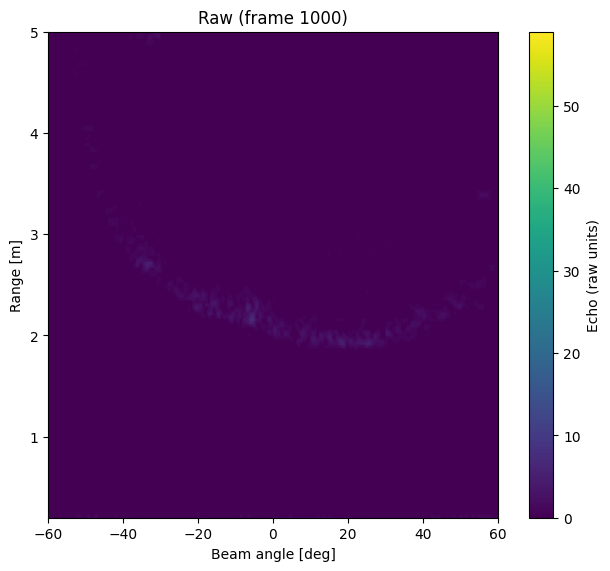

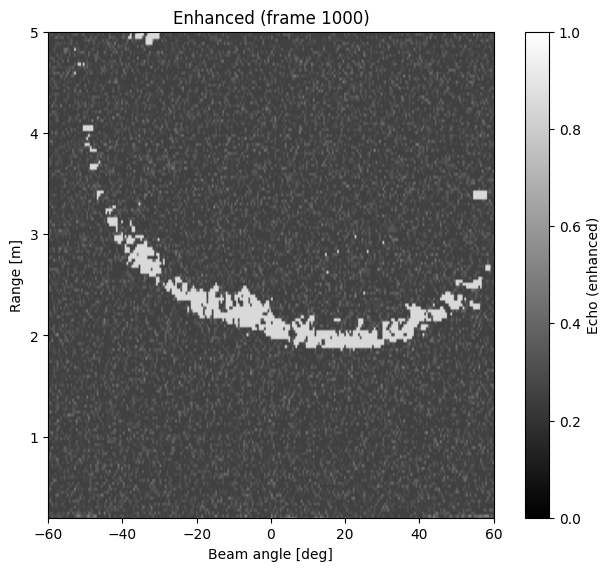

In [7]:
from utils.sonar_visualization import plot_raw_frame, plot_enhanced_frame, enhance_intensity, enhance_cfc_style


# fig = plot_raw_and_enhanced(M_raw, VIDEO_FRAME, SONAR_VIS_DEFAULTS)
fig1 = plot_raw_frame(M_raw, VIDEO_FRAME, SONAR_IMAGES_CONFIG)
fig2 = plot_enhanced_frame(M_raw, VIDEO_FRAME, SONAR_IMAGES_CONFIG, enhancer=enhance_cfc_style)
plt.show()


### Cone display

**DOC of code**:
What i want: I want a cone view where:
    - The data has a fov and the image should correctly display this. How does this work? Cartesian vs polar. We see the image in cartesian coordinaes, but then it has to be a cone view, to get the angels right. 


**Cone display**:
- First we can agian transpose and enhance it if needed.

- Then we set the actual limits of the cone and then the actual specs we want. We feed this to the cone_rasterizer_display_cell function. 

    ```python
     cone, (x_min, x_max, y_min, y_max), amid, ahalf = cone_rasterizer_display_cell(
        Z,
        fov_deg=fov,
        range_min_m=r_phys_min,
        range_max_m=r_phys_max,
        coneview_range_min_m=cv_rmin,
        coneview_range_max_m=cv_rmax,
        coneview_angle_min_deg=cv_amin,
        coneview_angle_max_deg=cv_amax,
        img_w=int(cfg["img_w"]),
        img_h=int(cfg["img_h"]),
        rotate_deg=float(cfg.get("rotate_deg", 0.0)),
        bg_value=np.nan,
    )
    ```
- See section about rasterizer for the code there. This will return. a "D float array in XY meters. A tuple of the extent fo imshow. amid and ahalf, The center angle and the half-width of the user window. 

- We now create the figure and cmap. set_bad means NaNs will render as black. the vmin and vmax are mostly for the colorbar.

- We create the image, set axis and add the colorbar:

    ```python
    im = ax.imshow(
        cone,
        origin="lower",
        extent=(x_min, x_max, y_min, y_max),
        aspect="equal",
        cmap=cmap,
        vmin=vmin, vmax=vmax,
    )
    ````




**cone_rasterizer_display_cell**:

- First we validate if the config-parameters for the angle and depth are valid.

- We get the mid angle. And also the half of the mid angle:
    ```python
    amid  = 0.5*(amin + amax)   # center angle
    ahalf = 0.5*(amax - amin)   # half angular span ≥ 0
    ```

    
- Build a symmetric output grid in XY. We always cover the radius up to cv_rmax (r1). The inner edge (below cv_rmin) will be masked, not cropped, so it stays circular.
    ```python
    y_min, y_max = 0.0, r1
    x_span = y_max * sin(ahalf)
    x_min, x_max = -x_span, +x_span

    ys = linspace(y_min, y_max, img_h, endpoint=False)
    xs = linspace(x_min, x_max, img_w, endpoint=False)
    Xc, Yc = meshgrid(xs, ys)
    ```

- Get “relative” angles and ranges.
    ```python
    theta_rel = deg(atan2(Xc, Yc))  # in the *centered view frame*
    rng       = hypot(Xc, Yc)
    ```
- ...

- Interpolating avoids blocky artifacts and respects sub-pixel geometry when mapping polar → Cartesian.
    ```python
    r0i = floor(r_idx); r1i = clip(r0i+1, 0, H-1)
    c0i = floor(beam_idx); c1i = clip(c0i+1, 0, W-1)

    fr = r_idx - r0i   # vertical fraction
    fc = beam_idx - c0i # horizontal fraction

    # Blend four neighbors
    Z00 = Z[r0i, c0i]; Z01 = Z[r0i, c1i]
    Z10 = Z[r1i, c0i]; Z11 = Z[r1i, c1i]
    top = Z00*(1-fc) + Z01*fc
    bot = Z10*(1-fc) + Z11*fc
    Zi  = top*(1-fr) + bot*fr
    ´´´




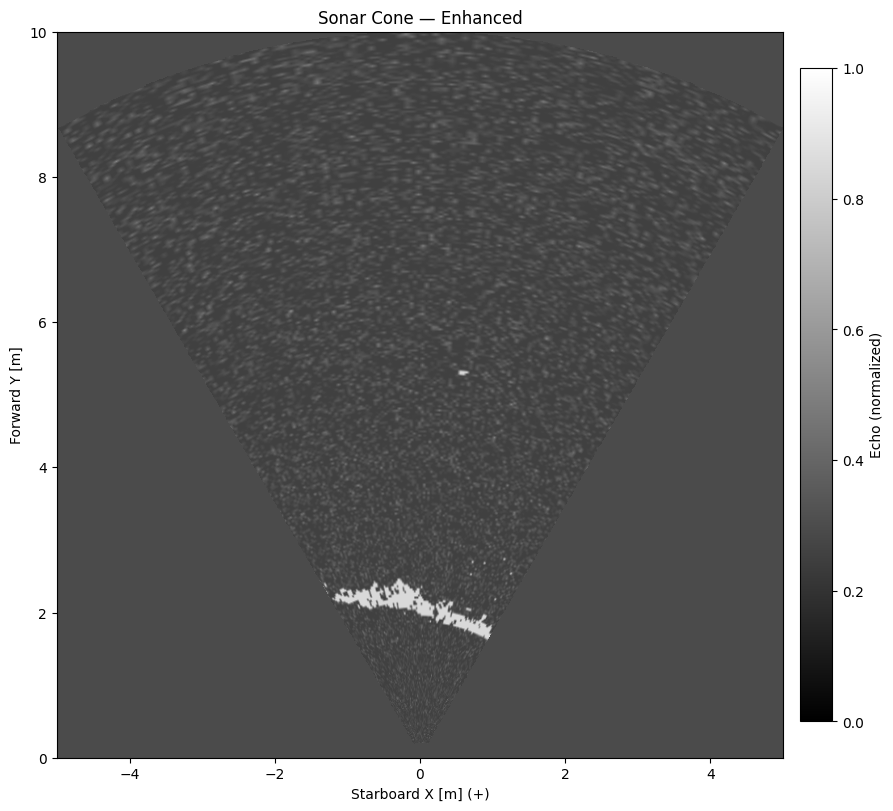

In [8]:
# Reuse the enhancer you used for Raw/Enhanced
# (the one you defined earlier with db/tvg/percentiles/gamma)
# Example name:
#   enhance_intensity(M, SONAR_VIS_DEFAULTS) -> [0,1]
# If you named it differently, pass that.

from utils.sonar_visualization import plot_cone_view, enhance_intensity, enhance_cfc_style


fig_cone = plot_cone_view(
    M_raw, 
    SONAR_IMAGES_CONFIG,
    use_enhanced=True,
    enhancer=enhance_cfc_style,   
)
plt.show()
